This notebook is the second part of an introduction to machine learning and implements an Multilayer Perceptron (MLP) for a binary classification task, from scratch.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

Dim of X: (2, 100)
Dim of Y: (1, 100)


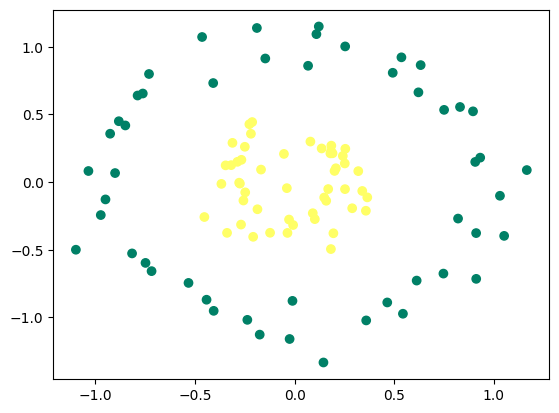

In [2]:
X,Y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
Y = Y.reshape((1,Y.shape[0]))

print(f"Dim of X: {X.shape}")
print(f"Dim of Y: {Y.shape}")

plt.scatter(X[0,:], X[1,:], c=Y, cmap='summer')
plt.show()

In [3]:
def initialisation(n0, n1, n2): 
    # n0:nb entree, n1: nb neurone, n2: sortie
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2, 1)

    parameters = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2
    }
    
    return(parameters)

In [4]:
def log_loss(A,Y):
    m = Y.shape[1]
    return(-1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)))

In [5]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

In [6]:
def foward_propagation(parameters, X):
    # we take X through the network and return the activations
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)

    activations = {
        'A1' : A1,
        'A2' : A2
    }

    return activations



In [7]:
def back_propagation(parameters, activations, X, Y):
    m = X.shape[1]
    A1, A2 = activations['A1'], activations['A2']
    W2 = parameters['W2']

    dZ2 = A2 - Y
    dZ1 = (W2.T).dot(dZ2) * A1 * (1 - A1)

    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return(gradients)


In [8]:
def update(parameters, gradients, lr):
    parameters['W1'] -= lr * gradients['dW1']
    parameters['b1'] -= lr * gradients['db1']
    parameters['W2'] -= lr * gradients['dW2']
    parameters['b2'] -= lr * gradients['db2']
    return(parameters)

In [9]:
# we see A as the probability for y=1
def predict(parameters, X):
    activations = foward_propagation(parameters, X)
    return activations['A2'] >= 0.5

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
W_history, b_history = [], []

In [37]:
def artificial_neuron(n1, X, Y, lr=0.001, n_iter=100000):
    n0, n2 = X.shape[0], Y.shape[0]
    parameters = initialisation(n0, n1, n2)

    Loss = []

    for i in range(n_iter):
        activations = foward_propagation(parameters, X)
        if i % 100 == 0:
            Loss.append(log_loss(activations['A2'],Y))
        gradients = back_propagation(parameters, activations, X, Y)
        parameters = update(parameters, gradients, lr)
        # W_history.append(W.copy())
        # b_history.append(b.copy())

    Y_pred = predict(parameters, X)
    print(accuracy_score(Y.ravel(), Y_pred.ravel()))
    
    plt.plot(Loss)
    plt.show()

    return(parameters)
    
    

1.0


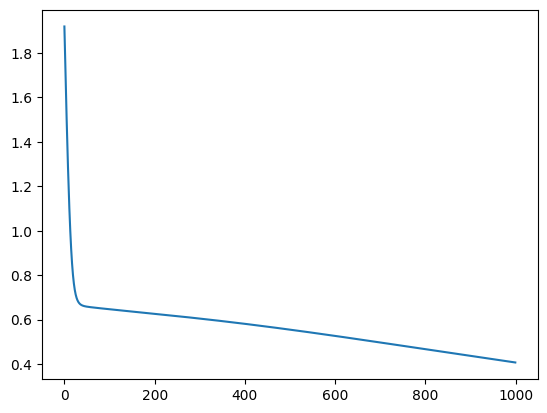

In [38]:
parameters = artificial_neuron(8,X,Y)